## <center>Drawing Detection and Classification<center> 

In [1]:
# calculate total execution time

from datetime import datetime
start_time = datetime.now()
 
print('Start Time: {}'.format(start_time)) 


Start Time: 2023-11-12 00:23:22.107620


## Importing Libraries

In [2]:
import numpy as np 
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours
from keras.models import load_model
# from rembg import remove
from PIL import Image

## Loading the Dataset 

In [3]:
x = []
y = []
datadir = 'dataset'
for folder in os.listdir(datadir):
    print(folder)
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
        
print(len(x))
print(len(y))
#print(f'labels : {list(set(y))}')
print(f'labels: {sorted(list(set(y)))}')


        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

apple
banana
candle
donut
envelope
flower
ice_cream
leaf
mug
umbrella
50000
50000
labels: ['apple', 'banana', 'candle', 'donut', 'envelope', 'flower', 'ice_cream', 'leaf', 'mug', 'umbrella']


### Time Update ###
End Time: 2023-11-12 00:28:08.696934
Duration: 0:04:46.589314


## Visualizing Images in the Dataset 

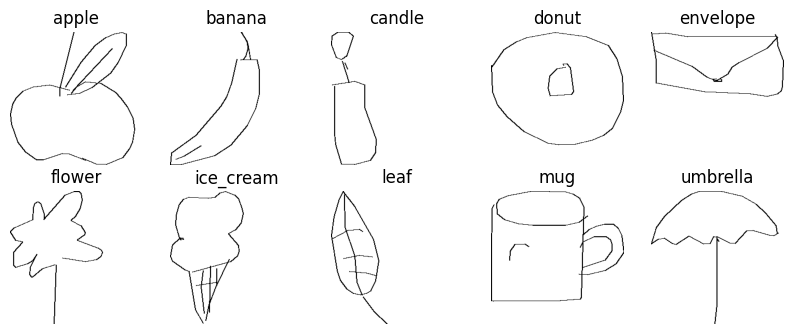

In [4]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(sorted(list(set(y)))):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

## Preprocessing the Data

In [5]:
X = []
for i in range(len(x)):
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, 
                        cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)

In [6]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(y)
print(Y)
print(len(y))

[0 0 0 ... 9 9 9]
50000


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))
        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

40000
10000
40000
10000


### Time Update ###
End Time: 2023-11-12 00:28:19.221134
Duration: 0:04:57.113514


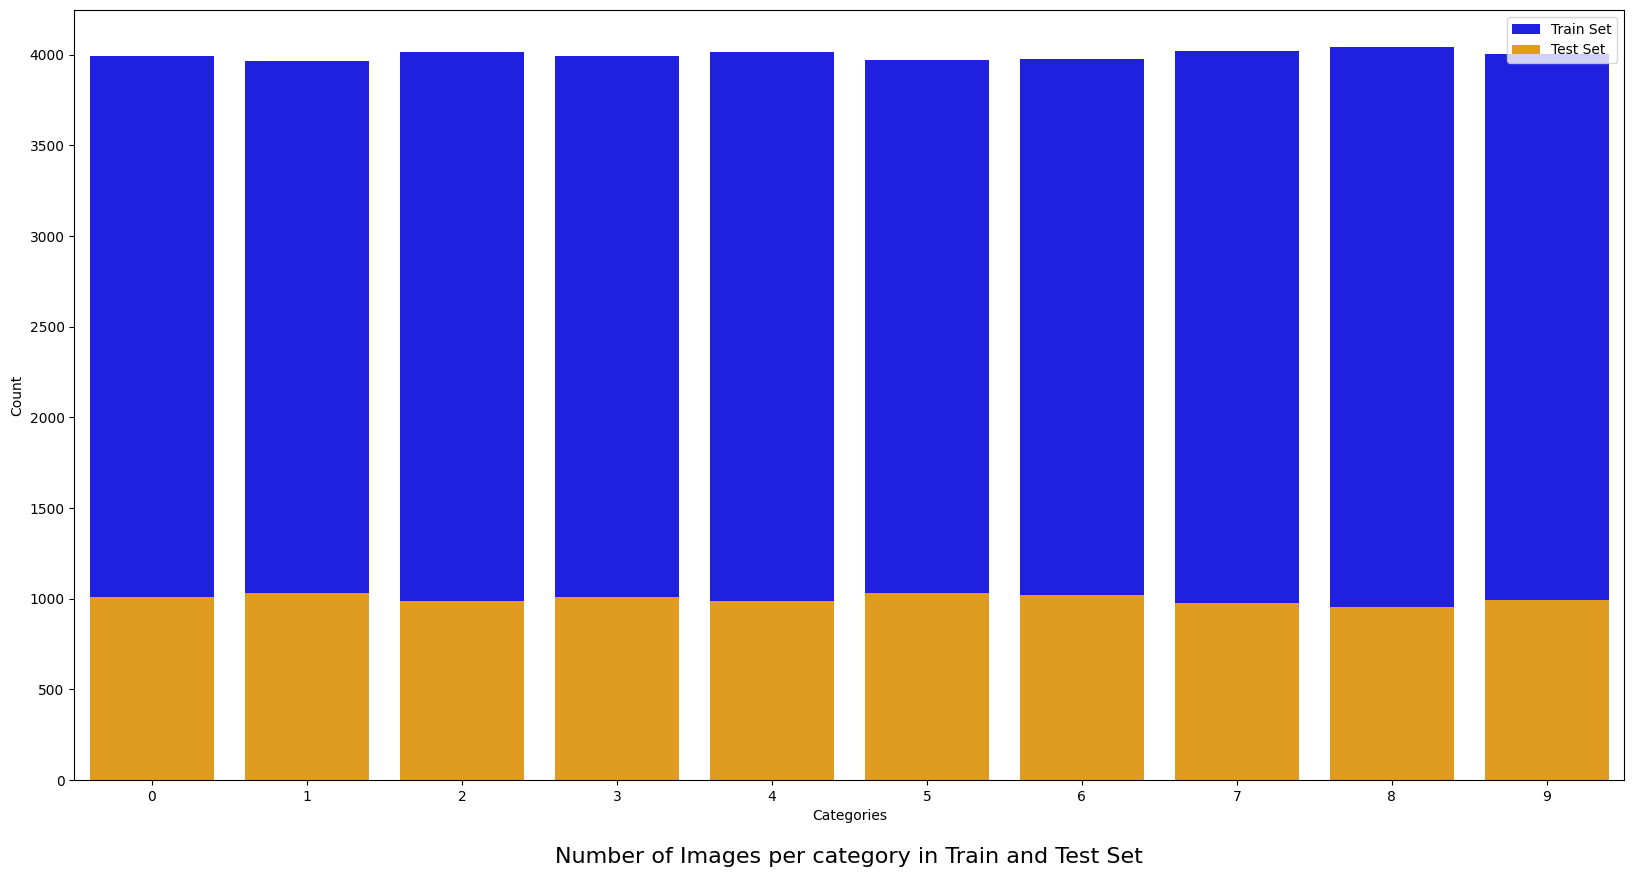

In [8]:

# Your code to get unique_train, count_train, unique_test, and count_test here
unique_train, count_train = np.unique(Y_train, return_counts=True)
unique_test, count_test = np.unique(Y_test, return_counts=True)

# Create a figure and axis for the combined bar chart
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the training data as a blue bar chart
sb.barplot(x=unique_train, y=count_train, ax=ax, color='blue', label='Train Set')

# Plot the test data as an orange bar chart
sb.barplot(x=unique_test, y=count_test, ax=ax, color='orange', label='Test Set')

# Set the title outside the box
ax.text(0.5, -0.1, 'Number of Images per category in Train and Test Set', transform=ax.transAxes, ha='center', va='center', fontsize=16)

# Add labels and legend
ax.set_xlabel('Categories')
ax.set_ylabel('Count')
ax.legend()

# Show the combined bar chart
plt.show()

## Defining the Model 

In [9]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(40000, 32, 32, 1)
(10000, 32, 32, 1)
(40000, 10)
(10000, 10)


In [10]:
def sketch_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                    kernel_initializer=glorot_uniform(seed=0), 
                    name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                    kernel_initializer=glorot_uniform(seed=0), 
                    name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                    kernel_initializer=glorot_uniform(seed=0), 
                    name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(10, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


In [11]:
model = sketch_recognition(input_shape=(32, 32, 1))
model.summary()

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                   

##  Training the Model

In [12]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('drawing_recognition.h5', 
                            monitor='val_loss', save_best_only=True, 
                            verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]


########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))



### Time Update ###
End Time: 2023-11-12 00:28:21.386628
Duration: 0:04:59.279008


In [13]:
aug = ImageDataGenerator(zoom_range=0.1,
                        width_shift_range=0.05,
                        height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=40, validation_data=(X_test, Y_test))

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

Epoch 1/40
313/313 [==============================] - 28s 85ms/step - loss: 1.3313 - accuracy: 0.5980 - val_loss: 0.8930 - val_accuracy: 0.7650
Epoch 2/40
313/313 [==============================] - 26s 85ms/step - loss: 0.7792 - accuracy: 0.7793 - val_loss: 0.6173 - val_accuracy: 0.8470
Epoch 3/40
313/313 [==============================] - 28s 90ms/step - loss: 0.6361 - accuracy: 0.8205 - val_loss: 0.5886 - val_accuracy: 0.8547
Epoch 4/40
313/313 [==============================] - 28s 90ms/step - loss: 0.5692 - accuracy: 0.8391 - val_loss: 0.5245 - val_accuracy: 0.8754
Epoch 5/40
313/313 [==============================] - 28s 88ms/step - loss: 0.5229 - accuracy: 0.8537 - val_loss: 0.4790 - val_accuracy: 0.8819
Epoch 6/40
313/313 [==============================] - 29s 93ms/step - loss: 0.4904 - accuracy: 0.8629 - val_loss: 0.4274 - val_accuracy: 0.8992
Epoch 7/40
313/313 [==============================] - 29s 91ms/step - loss: 0.4675 - accuracy: 0.8661 - val_loss: 0.3878 - val_accuracy:

##  Loss and Accuracy Plot

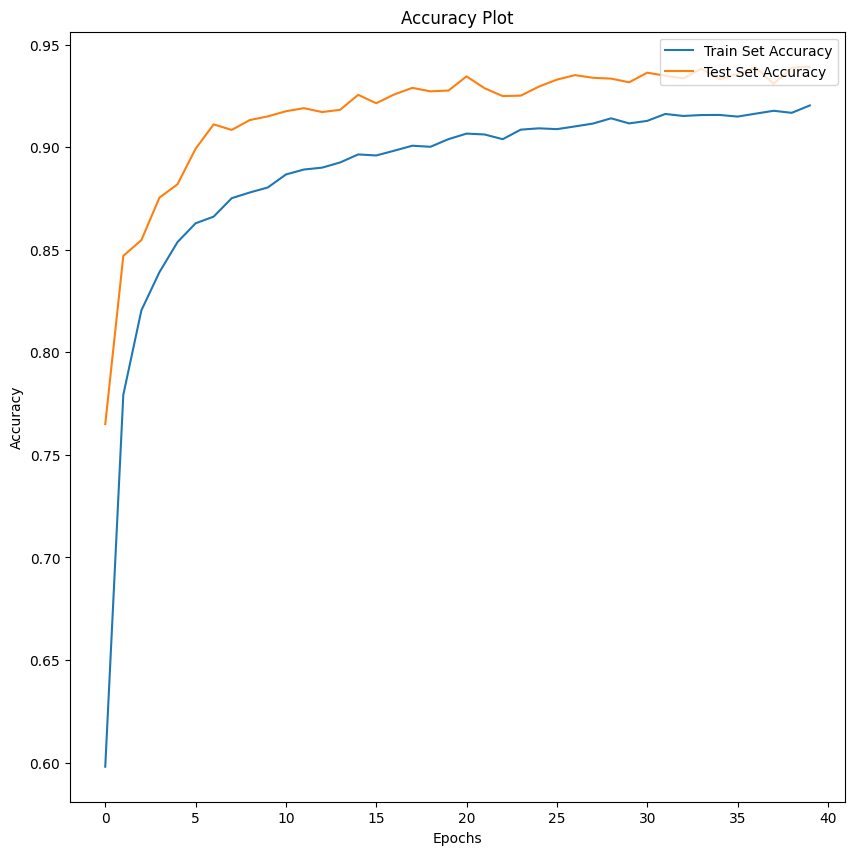

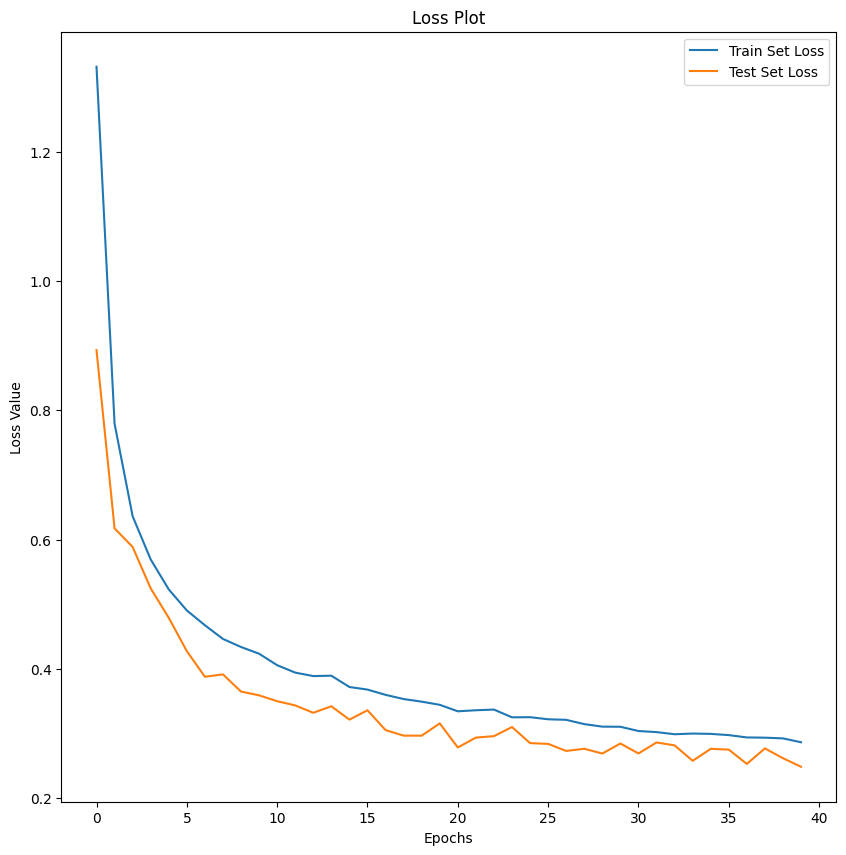

In [14]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

## Confusion Matrix 

313/313 [==============================] - 3s 8ms/step


<Axes: >

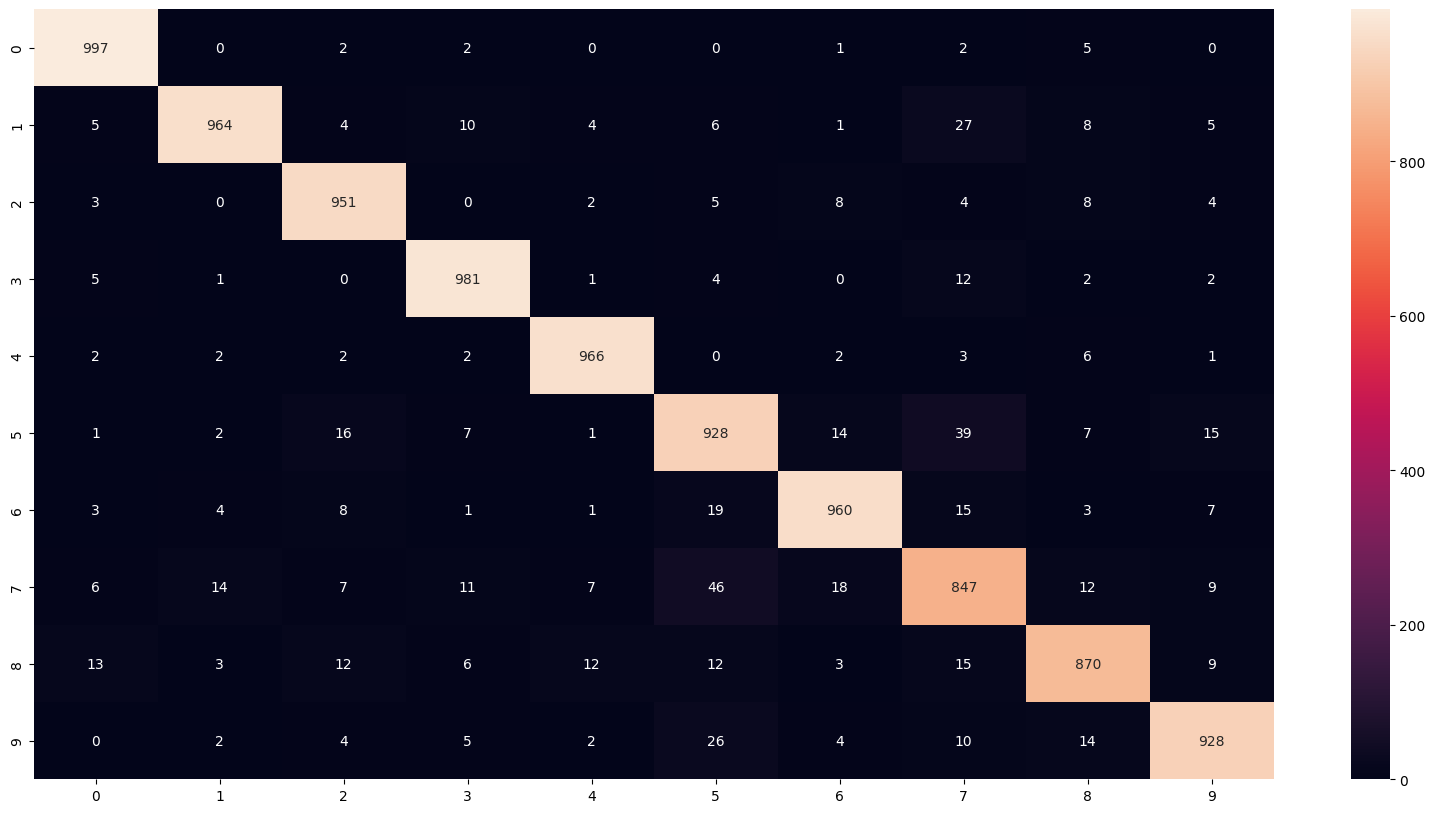

In [15]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)

matrix = confusion_matrix(Y_test_hat, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
                     columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
figure = plt.figure(figsize=(20, 10))
sb.heatmap(df_cm, annot=True, fmt='d')

## Classification Report

In [16]:
print(classification_report(Y_test_hat, ypred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1009
           1       0.97      0.93      0.95      1034
           2       0.95      0.97      0.96       985
           3       0.96      0.97      0.97      1008
           4       0.97      0.98      0.97       986
           5       0.89      0.90      0.89      1030
           6       0.95      0.94      0.94      1021
           7       0.87      0.87      0.87       977
           8       0.93      0.91      0.92       955
           9       0.95      0.93      0.94       995

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



## Saving the Model 

In [17]:
model.save('sketch_recognition_cnn.keras')

## Total Execution Time

In [18]:
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))



### Time Update ###
End Time: 2023-11-12 00:46:27.603801
Duration: 0:23:05.496181
